In [463]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from pyearth import Earth
import random
import itertools

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix

#Library to compute pair-wise Euclidean distance between all observations in the data
from sklearn import metrics
#Library to impute missing values with the KNN algorithm
from sklearn import impute
from sklearn.decomposition import PCA

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [464]:
import warnings
warnings.filterwarnings('ignore')

In [465]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [466]:
# Split data into X and y
y_train = train.y
X_train = train.drop(['id', 'y'], axis=1) 

X_test = test.drop('id', axis=1)

#### Shape of data

In [467]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(5380, 765)
(5380,)
(4403, 765)


#### Data types

In [468]:
# Looking at datatypes
dtypes = pd.DataFrame({'type':train.dtypes.value_counts()})
dtypes
labels=['float64', 'int64', 'object']
dtypes

,type
float64,657
int64,99
object,11


([<matplotlib.patches.Wedge at 0x7fc9cc29cb20>,
 [Text(-0.4790111678338591, -0.9902263888073487, 'float64'),
  Text(0.5231250957206647, 0.9676466990731926, 'int64'),
  Text(0.04954432974216901, 1.0988836878352501, 'object')])

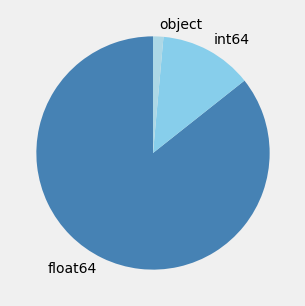

In [469]:
colors = ['steelblue', 'skyblue', 'lightblue']
fig, ax = plt.subplots(figsize =(5,5))
ax.pie(dtypes.type, labels = labels, colors = colors,startangle = 90)
#plt.savefig('my_plot.png', transparent=True)

In [470]:
train.select_dtypes(include=['object']).head()

,x039,x117,x154,x189,x266,x320,x379,x435,x689,x700,x707
0,1276315487270499940040704,3867048740925900161725707059200,299156858996100004052992,1681100077920000000,695399847665449959424,5014437024912100023547866382336,38262568538403001987429407171583305318400,573000000000000,26984724631896000579589654347723369873408,5710000000000000000,586885589994299981824
1,14307512619168000076472454742016,9465643212201800471249158144,21891802256762999393105534255104,2162081933417700042735616,6380000000000000000,11665382397911000625585324032,21636796821355001238195071862121168896,5650000000000,16375497434045999925088695685516099584,1514431683883399926251520,5550000000000000000
2,47525543472235003561115648,270997374075120014554669514752,147436426304199992541184,825000000000000000,109784589505270005760,381823515042379998785464958976,1459494402122199951062831474178785280000,35839005138,896214270462010001534971661362684493824,77223513438553997312,88897890482495995904
3,924173667994069945955479715840,66286071954144998593205895168,4598319105678500062285529088,3543721127737899876352,32341271230321999872,78641048654138998481053810688,195683294443749990132258679496787361792,1150000000000,157366888067590007223514892311617077248,178140452251780002086912,28732631875074998272
4,118694919641369992495104,67561575735033000831477612544,1993099050548699955462144,5770000000000000000,49950023667033997312,80129496654926997035344199680,132711814512699993676926086282945232896,20500000000000,105328788427959996919829577167431270400,824000000000000000,44666736442821001216


#### Missing values

In [471]:
train.isna().sum()

id        0
x001     10
x002      0
x003      3
x004      0
       ... 
x762     53
x763      0
x764      3
x765    375
y         0
Length: 767, dtype: int64

In [472]:
# Features with more than one NA value
num_na = pd.DataFrame(train.isnull().sum(),columns=['result'])
num_na[num_na['result']>0].sort_values(by='result', ascending=False).head()

,result
x147,863
x748,863
x090,763
x641,763
x597,759


In [473]:
# # Missing Values
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
missing_values_table(train).head(10)

Your selected dataframe has 767 columns.
There are 473 columns that have missing values.


,Missing Values,% of Total Values
x147,863,16.0
x748,863,16.0
x090,763,14.2
x641,763,14.2
x597,759,14.1
x701,759,14.1
x273,741,13.8
x738,741,13.8
x399,707,13.1
x677,707,13.1


#### Scale data

In [474]:
X_train.describe()

# Many diff magnitudes
    # Cannot have +- inf for certain analyses
    # Also need to scale before imputation

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
count,5.370000e+03,5380.000000,5377.000000,5380.000000,5.370000e+03,5380.000000,5.377000e+03,5.377000e+03,5.327000e+03,5.380000e+03,...,5378.000000,5380.000000,5.380000e+03,5375.000000,5327.000000,5380.000000,5327.000000,5380.000000,5377.000000,5005.000000
mean,4.623269e+10,14205.468080,6.412851,0.003794,2.978719e+09,0.257727,4.663239e+06,1.968919e+06,2.993064e+05,1.402639e+17,...,0.363471,0.028403,1.031942e+13,0.337180,91.147175,1.931784,49.840248,11.524413,92.241702,0.947097
std,5.214063e+10,11869.274255,0.818170,0.012201,1.860480e+09,0.178621,7.584579e+06,1.690079e+06,1.020525e+06,5.513045e+17,...,0.418773,0.118124,2.626909e+13,0.283159,304.977636,2.379576,170.597793,13.131103,92.728317,4.060325
min,1.135681e+09,3.800000,1.000000,0.000000,5.645178e+08,0.000000,4.945000e+02,1.000000e+00,1.000000e+00,8.779690e+05,...,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.990000
25%,1.105853e+10,5226.627500,5.930000,0.000300,1.547443e+09,0.000000,4.861619e+05,6.638580e+05,8.189500e+03,6.930000e+13,...,0.080000,0.000200,2.913046e+09,0.070000,3.000000,0.000000,2.000000,3.364125,20.720000,-0.620000
50%,2.767335e+10,11152.340000,6.360000,0.000900,2.138110e+09,0.310000,1.736036e+06,1.514608e+06,3.631900e+04,2.110000e+15,...,0.234300,0.001000,4.210000e+11,0.270000,12.000000,1.000000,6.000000,6.742150,59.970000,-0.180000
75%,6.266054e+10,19231.150000,6.860000,0.002700,4.460250e+09,0.400000,6.082900e+06,2.881438e+06,1.271430e+05,4.402500e+16,...,0.499175,0.004400,9.265000e+12,0.550000,37.000000,3.000000,18.000000,14.204225,135.830000,0.670000
max,4.950000e+11,56364.780000,11.000000,0.342000,9.848333e+09,0.500000,6.763421e+07,7.936897e+06,8.411828e+06,7.190000e+18,...,5.570700,1.000000,2.000000e+14,1.000000,2106.000000,24.000000,1165.000000,110.527800,421.200000,53.820000


In [475]:
# When dealing with variance (PCA, clustering, logistic regression, SVMs, neural networks) 
    # Standard Scaler may be very important
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [476]:
# scaler = MinMaxScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [477]:
# Turn scaled data into dataframe
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns

#### Impute missing values

In [478]:
# Imputing missing values with KNNImputer (arbitrary n_neighbors val)
imputer = impute.KNNImputer(n_neighbors=3, weights="uniform")

# Use the object method 'fit_transform' to impute missing values
X_train_imputed = imputer.fit_transform(X_train_scaled)

In [479]:
X_train_imputed = pd.DataFrame(X_train_imputed) # Make it into a df
X_train_imputed.columns = X_train.columns # Rename cols 
X_train_imputed.head(3)

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,0.970273,-0.607871,1.646693,0.000475,1.290159,0.292676,-0.579799,-0.612065,-0.279066,-0.254397,...,2.883044,-0.234542,-0.392860,-0.731739,-0.282497,1.289516,-0.280453,-0.229378,-0.840832,-0.418012
1,-0.823386,-0.024523,-1.274733,-0.298702,-0.712955,-1.443005,0.957888,-0.101110,0.736911,0.052129,...,-0.587892,0.721319,-0.266476,-0.908335,1.868682,-0.811894,1.759624,-0.758149,0.732081,-0.323594
2,-0.269359,-0.860578,-0.785792,-0.302801,-0.270175,-1.443005,-0.512779,-0.942754,-0.152057,-0.254201,...,0.226228,-0.215916,-0.392868,0.186557,-0.171003,0.028670,-0.186657,-0.140474,-0.724568,-0.353972


#### Drop meaningless columns

In [480]:
(X_train_imputed.nunique() < 10).value_counts()

False    746
True      19
dtype: int64

In [481]:
(X_train_imputed.nunique() == 1).value_counts()

False    754
True      11
dtype: int64

In [482]:
# Find columns with all the same value
same_val_cols = [col for col in X_train_imputed.columns if X_train_imputed[col].nunique() == 1]

# Filter the dataframe for these columns
df_same_vals = X_train_imputed[same_val_cols]
df_same_vals.columns

Index(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594',
       'x643', 'x703'],
      dtype='object')

In [483]:
X_train_imputed = X_train_imputed.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis=1)
(X_train_imputed.nunique() == 1).value_counts()

False    754
dtype: int64

#### Drop highly correlated columns

In [484]:
corr_matrix = X_train_imputed.corr()

In [485]:
# Find the highly correlated features
threshold = 0.99
high_corr_pairs = np.where(corr_matrix > threshold)

# Check if there are highly correlated pairs
if len(high_corr_pairs[0]) > 0:
    # Print the pairs of highly correlated features
    for i, j in zip(*high_corr_pairs):
        if i != j:
            print(f'({X_train_imputed.columns[i]}, {X_train_imputed.columns[j]})')
else:
    print('No highly correlated pairs of features found.')

(x001, x485)
(x002, x158)
(x002, x331)
(x002, x474)
(x005, x636)
(x007, x145)
(x007, x197)
(x007, x387)
(x011, x123)
(x011, x214)
(x011, x269)
(x011, x492)
(x011, x534)
(x011, x644)
(x011, x714)
(x012, x065)
(x012, x071)
(x012, x084)
(x012, x120)
(x012, x143)
(x012, x182)
(x012, x278)
(x012, x313)
(x012, x351)
(x012, x393)
(x012, x433)
(x012, x442)
(x012, x544)
(x012, x546)
(x012, x573)
(x012, x678)
(x012, x705)
(x012, x760)
(x012, x762)
(x019, x277)
(x019, x439)
(x019, x621)
(x020, x054)
(x020, x571)
(x021, x078)
(x021, x095)
(x021, x184)
(x021, x204)
(x021, x232)
(x021, x259)
(x021, x295)
(x021, x348)
(x021, x370)
(x021, x384)
(x021, x424)
(x021, x450)
(x021, x494)
(x021, x529)
(x021, x535)
(x021, x592)
(x021, x593)
(x021, x596)
(x021, x605)
(x021, x613)
(x021, x628)
(x021, x682)
(x021, x754)
(x023, x188)
(x024, x081)
(x028, x332)
(x029, x040)
(x029, x041)
(x029, x087)
(x029, x159)
(x029, x206)
(x029, x210)
(x029, x230)
(x029, x252)
(x029, x271)
(x029, x339)
(x029, x367)
(x029, x372)

(x531, x666)
(x531, x681)
(x531, x722)
(x531, x726)
(x531, x763)
(x533, x462)
(x533, x525)
(x534, x011)
(x534, x123)
(x534, x214)
(x534, x269)
(x534, x492)
(x534, x644)
(x534, x714)
(x535, x021)
(x535, x078)
(x535, x095)
(x535, x184)
(x535, x204)
(x535, x232)
(x535, x259)
(x535, x295)
(x535, x348)
(x535, x370)
(x535, x384)
(x535, x424)
(x535, x450)
(x535, x494)
(x535, x529)
(x535, x592)
(x535, x593)
(x535, x596)
(x535, x605)
(x535, x613)
(x535, x628)
(x535, x682)
(x535, x754)
(x536, x033)
(x536, x107)
(x536, x112)
(x536, x126)
(x536, x129)
(x536, x149)
(x536, x198)
(x536, x245)
(x536, x319)
(x536, x322)
(x536, x325)
(x536, x330)
(x536, x346)
(x536, x412)
(x536, x426)
(x536, x531)
(x536, x571)
(x536, x666)
(x536, x681)
(x536, x722)
(x536, x726)
(x536, x763)
(x539, x042)
(x539, x550)
(x539, x608)
(x543, x569)
(x543, x755)
(x544, x012)
(x544, x065)
(x544, x071)
(x544, x084)
(x544, x120)
(x544, x143)
(x544, x182)
(x544, x278)
(x544, x313)
(x544, x351)
(x544, x393)
(x544, x433)
(x544, x442)

In [486]:
len(np.unique(high_corr_pairs))

754

In [487]:
len(high_corr_pairs[0])

4236

In [488]:
features_to_drop = set()
for i, j in zip(*high_corr_pairs):
    if i != j:
        corr_ij = corr_matrix.iloc[i, j]
        if i not in features_to_drop and j not in features_to_drop:
            if abs(corr_matrix.iloc[i, -1]) > abs(corr_matrix.iloc[j, -1]):
                features_to_drop.add(j)
            else:
                features_to_drop.add(i)

In [489]:
len(features_to_drop)

277

In [490]:
train.corrwith(train.x029).abs().sort_values(ascending=False).head(5)

x029    1.000000
x458    1.000000
x230    1.000000
x040    0.999997
x565    0.999997
dtype: float64

In [491]:
X_train_vif = X_train_imputed.copy()

X_train_vif = add_constant(X_train_vif)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_vif.columns

for i in range(len(X_train_vif.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X_train_vif.values, i)

In [492]:
vif_data.sort_values(by='VIF', ascending=False)[0:157]

,feature,VIF
408,x413,inf
539,x547,inf
694,x705,inf
369,x372,inf
122,x123,inf
...,...,...
58,x058,inf
399,x403,inf
55,x055,inf
60,x060,9.007199e+15


In [416]:
X_vif = X_train_imputed.copy()
len(X_vif)

5380

In [419]:
X_train_imputed.shape

(5380, 755)

In [420]:
vif_data.shape

(755, 2)

In [423]:
threshold = 9.007199e+15

to_drop=[]
# Iterate until there are no more features with VIF above the threshold
while max_vif > threshold:
    # Get the index of the feature with the highest VIF score
    max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Features']
    
    # Remove the feature with the highest VIF score from the X_vif DataFrame
    X_vif = X_vif.drop(max_vif_feature, axis=1).dropna()
    
    # Recompute the VIF scores
    vif_data = pd.DataFrame({'Features': X_vif.columns})
    vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    
    # Add the selected feature to the list of features to drop
    to_drop.append(max_vif_feature)
    
    # Get the new maximum VIF score
    max_vif = vif_data['VIF'].max()

KeyError: 'VIF'

In [414]:
# Set the initial threshold VIF score
threshold = 9.007199e+15

# Initialize a list to store the features to drop
to_drop = []

# Iterate until there are no features left with VIF scores above the threshold
while vif_data['VIF'].max() > threshold:
    # Select the feature with the highest VIF score
    max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
    
    # Remove the selected feature from the dataframe
    X_vif = X_vif.drop(max_vif_feature, axis=1)
    
    # Recompute the VIF scores
    vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    
    # Add the selected feature to the list of features to drop
    to_drop.append(max_vif_feature)

# Print the list of features to drop
print(to_drop)
print(len(to_drop))

ValueError: Length of values (754) does not match length of index (755)

In [53]:
object_cols = train.select_dtypes(include=['object']).columns
list(object_cols)

['x039',
 'x117',
 'x154',
 'x189',
 'x266',
 'x320',
 'x379',
 'x435',
 'x689',
 'x700',
 'x707']

## EDA Visualizations

In [197]:
X_train_imputed.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,0.193743,0.123975,0.676,0.011111,0.518568,0.62,0.003927,0.117751,0.001728,3.741307e-06,...,0.281957,0.0007,1.486405e-06,0.13,0.002374,0.208333,0.001717,0.077019,0.033903,0.004379
1,0.004392,0.246813,0.437,0.000439,0.117181,0.00,0.176351,0.226543,0.124975,2.350487e-02,...,0.021057,0.1136,1.660000e-02,0.08,0.313865,0.000000,0.300429,0.014205,0.380152,0.042206
2,0.062879,0.070761,0.477,0.000292,0.205906,0.00,0.011442,0.047341,0.017136,1.877608e-05,...,0.082252,0.0029,5.023741e-07,0.39,0.018519,0.083333,0.015451,0.087580,0.059497,0.009122
3,0.023780,0.282707,0.486,0.000585,0.170420,0.00,0.093502,0.243432,0.001195,5.146036e-03,...,0.068501,0.0000,1.740000e-03,0.25,0.000950,0.041667,0.000000,0.041000,0.279582,0.047984
4,0.059730,0.064179,0.652,0.001754,0.089181,0.42,0.002504,0.059753,0.002130,8.344922e-07,...,0.001795,0.0005,5.477329e-07,0.11,0.005223,0.041667,0.002575,0.147218,0.013794,0.010400


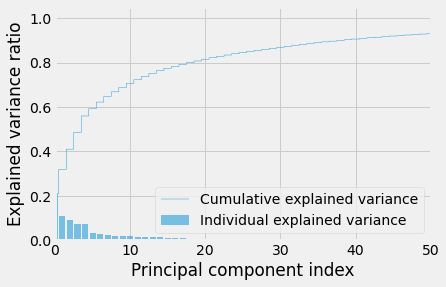

In [234]:
pca = PCA()
pca.fit_transform(X_train_imputed)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance', linewidth=0.4)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.xlim(0, 50)
plt.show()

Text(0.5, 1.0, 'Loss Distribution')

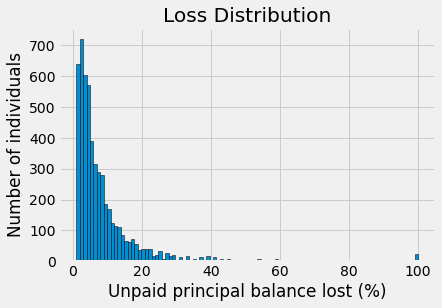

In [214]:
figsize=(8, 8)

# Histogram of the loss
plt.style.use('fivethirtyeight')
plt.hist(train['y'], bins = 100, edgecolor = 'k')
plt.xlabel('Unpaid principal balance lost (%)') 
plt.ylabel('Number of individuals');
plt.title('Loss Distribution')

<AxesSubplot:xlabel='x001', ylabel='Count'>

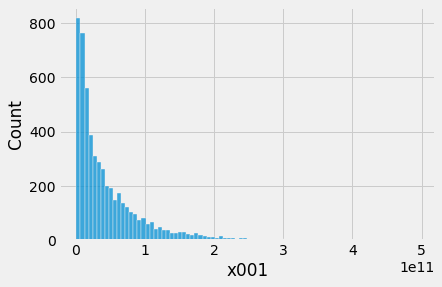

In [211]:
import seaborn as sns
sns.histplot(train.x001)

<AxesSubplot:xlabel='x146', ylabel='Count'>

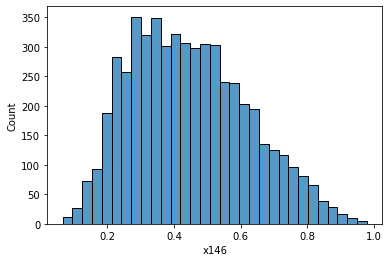

In [11]:
sns.histplot(train.x146)

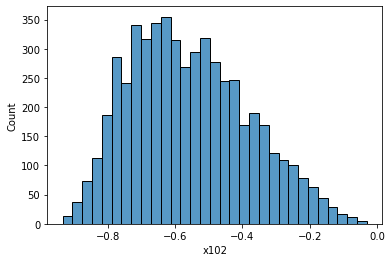

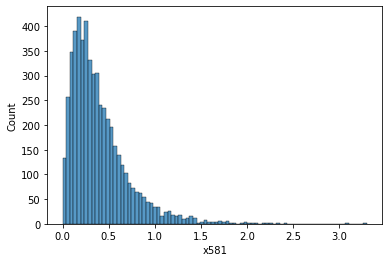

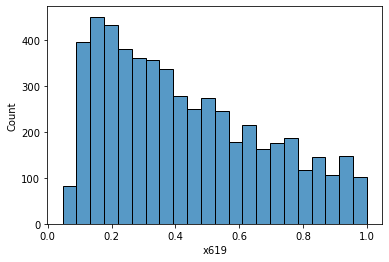

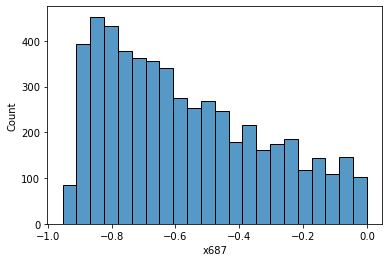

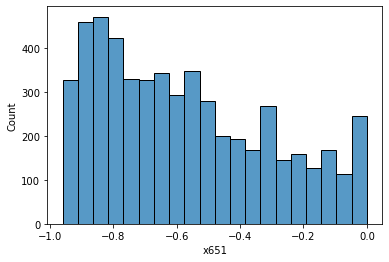

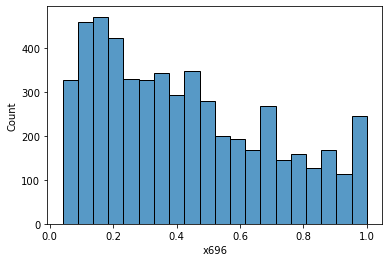

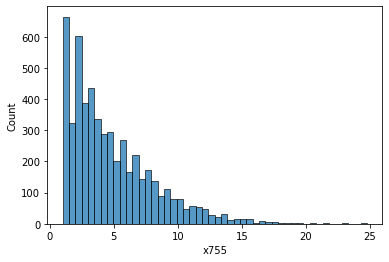

In [20]:
sns.histplot(train.x102)
plt.show()
sns.histplot(train.x581)
plt.show()
sns.histplot(train.x619)
plt.show()
sns.histplot(train.x687)
plt.show()
sns.histplot(train.x651)
plt.show()
sns.histplot(train.x696)
plt.show()
sns.histplot(train.x755)
plt.show()

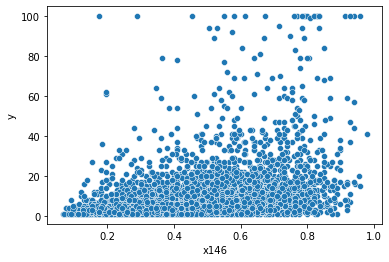

In [21]:
sns.scatterplot(data=train, x='x146', y='y')
plt.show()

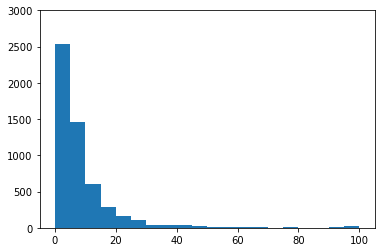

In [22]:
fig , ax = plt.subplots()
plt.hist(train.y, bins = 20, range=(0,100))
ax.set_ylim([0,3000])
plt.show()

In [119]:
# Create an object of type MinMaxScaler
scaler = MinMaxScaler()

# Use the object method 'fit_transform' to scale the values to a standard uniform distribution
scaled_train = pd.DataFrame(scaler.fit_transform(train))

#Imputing missing values with KNNImputer

# Define an object of type KNNImputer
imputer = impute.KNNImputer(n_neighbors=3, weights="uniform")

#Use the object method 'fit_transform' to impute missing values
imputed_arr2 = imputer.fit_transform(scaled_train)

unscaled_train = scaler.inverse_transform(imputed_arr2)

train_imputed = pd.DataFrame(unscaled_train) # make it into a df
train_imputed.columns = train.columns # rename cols 

In [126]:
y_train_imputed = train_imputed.y
X_train_imputed2 = train_imputed.drop(['id', 'y'], axis=1)

In [151]:
# Create an object of type MinMaxScaler
scaler = MinMaxScaler()

# Use the object method 'fit_transform' to scale the values to a standard uniform distribution
scaled_test = pd.DataFrame(scaler.fit_transform(X_test))

#Imputing missing values with KNNImputer

# Define an object of type KNNImputer
imputer = impute.KNNImputer(n_neighbors=3, weights="uniform")

#Use the object method 'fit_transform' to impute missing values
imputed_arr = imputer.fit_transform(scaled_test)

unscaled_test = scaler.inverse_transform(imputed_arr)

test_imputed = pd.DataFrame(unscaled_test) # make it into a df
test_imputed.columns = X_test.columns # rename cols 

In [152]:
X_test.shape

(4403, 765)

## Model
Ideas
- look at feature importance with MARS
- look at collinearity, VIF
- impute missing values
- natural cubic splines
- bagging

In [ ]:
cv_scores = []
degrees = range(1, 5)

for d in degrees:
    model = Earth(max_terms=500, max_degree=d)
    scores = cross_val_score(model, X_train_imputed, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(np.mean(np.sqrt(-scores)))
    
# Find the best degree
optimal_degree = degrees[np.argmin(cv_scores)] # argmin
optimal_degree

In [168]:
mars_model = Earth(feature_importance_type='rss', max_degree=4)
mars_model.fit(X_train_imputed, y_train)

print(mars_model.summary())

Earth Model
-----------------------------------------------------------------------
Basis Function                                   Pruned  Coefficient   
-----------------------------------------------------------------------
(Intercept)                                      No      34.1515       
h(x521-261159)                                   Yes     None          
h(261159-x521)                                   No      2.33372e-05   
h(x205-459589)                                   Yes     None          
h(459589-x205)                                   No      7.7801e-06    
h(x321-6.5741E+08)                               Yes     None          
h(6.5741E+08-x321)                               No      9.13776e-09   
h(x102+0.09)                                     Yes     None          
h(-0.09-x102)                                    Yes     None          
h(x348-119.36)*h(x521-261159)                    Yes     None          
h(119.36-x348)*h(x521-261159)                    No 

In [169]:
feature_df = pd.DataFrame({'Predictors':X_train.columns, 'Importance': mars_model.feature_importances_}).sort_values(by='Importance', ascending=False)[0:25]
feature_df

,Predictors,Importance
354,x355,99069.827738
560,x561,60514.984569
252,x253,48964.417559
101,x102,38301.460095
526,x527,6934.718382
320,x321,2052.464057
298,x299,884.706027
505,x506,0.000000
506,x507,0.000000
507,x508,0.000000


### NCS

In [107]:
combinations = list(itertools.product([3, 4, 5, 6], repeat=4))

predictors = feature_df.loc[:, "Predictors"]
predictors = predictors.reset_index().drop("index", axis=1).Predictors

In [117]:
scores = []
for comb in combinations:
    matrix = dmatrix('cr(' + predictors[0] + ", df = " + str(comb[0]) + ')' + 
            '*cr(' + predictors[1] + ", df = " + str(comb[1]) + ')' + 
            '*cr(' + predictors[2] + ", df = " + str(comb[2]) + ')' + 
            '*cr(' + predictors[3] + ", df = " + str(comb[3]) + ')' , data = X_train_imputed, return_type = "dataframe") 
    
    lin_reg = LinearRegression()
    score = cross_val_score(lin_reg, matrix, y_train, cv = 5, scoring = "neg_root_mean_squared_error")
    
    scores.append(-1*np.mean(score))
    
    
optimal_degrees = combinations[scores.index(min(scores))]

KeyboardInterrupt: 

## Bagged Trees

In [137]:
y_train_imputed.astype(np.float32)

0        5.0
1        1.0
2       11.0
3        1.0
4        5.0
        ... 
5375     4.0
5376     8.0
5377    21.0
5378    13.0
5379    28.0
Name: y, Length: 5380, dtype: float32

In [144]:
X_train_imputed2 = np.float32(X_train_imputed2)
X_train_imputed2=np.nan_to_num(X_train_imputed2, posinf=33333333, neginf=-33333333)

In [145]:
bagged_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=1,
                        n_jobs=-1).fit(X_train_imputed2, y_train_imputed.astype(np.float32))

## Make predictions

In [160]:
X_test = np.float32(X_test)
X_test=np.nan_to_num(X_test, posinf=33333333, neginf=-33333333)

In [161]:
y_pred_bagged = bagged_model.predict(X_test)
y_pred_bagged.shape

(4403,)

In [162]:
y_pred_bagged

array([ 5.7,  6.5,  3.6, ...,  8.2, 13.3, 33.3])

In [163]:
y_pred

array([ 9.89327224, 10.6499889 ,  1.87575875, ..., 14.01418392,
       17.16843164, 20.23517333])

In [173]:
y_pred = mars_model.predict(X_test)
y_pred.shape

(4403,)

In [76]:
X_test.shape

(4403, 765)

In [77]:
test.iloc[:,0]

0       5380
1       5381
2       5382
3       5383
4       5384
        ... 
4398    9778
4399    9779
4400    9780
4401    9781
4402    9782
Name: id, Length: 4403, dtype: int64

In [174]:
predictions = pd.DataFrame({"id":test.iloc[:, 0], "y":y_pred})
predictions

,id,y
0,5380,5.816430
1,5381,6.414940
2,5382,1.323714
3,5383,2.815735
4,5384,10.009980
...,...,...
4398,9778,14.780076
4399,9779,8.745940
4400,9780,12.926180
4401,9781,17.756419


In [175]:
# Writing the predictions into a csv
predictions.to_csv("regression_pred4.csv", index = False)

## Ideas

- Figure out how to use NCS. 
- Use bagged trees for values that are not inf/-inf. Use a diff model for everything else.